# Data Exploration with Spark
### Kwame V. Taylor

Answer the questions below by using a combination of the techniques discussed in the lesson that you think is appropriate.

### Exercises

* How many different cases are there, by department?

* Does the percentage of cases that are late vary by department?

* On average, how late are the late cases by department?

* What is the service type that is the most late? Just for Parks & Rec?

* For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

* Does whether or not its a weekend matter for when a case is opened/closed?

* On average, how many cases are opened a day for the Customer Service department?

* Does the number of service requests for the solid waste department vary by day of the week?

### Set up Environment

In [23]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib as mpl

from cycler import cycler
import seaborn as sns

# default viz size settings
plt.rc('figure', figsize=(10, 7))
plt.rc('font', size=14)
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linestyle'] = '--'
mpl.rcParams['axes.prop_cycle'] = cycler(color=['deepskyblue', 'firebrick', 'darkseagreen', 'violet'])

import warnings
warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

from wrangle import wrangle_311

def spark_shape(self):
    return (self.count(), len(self.columns))
pyspark.sql.dataframe.DataFrame.shape = spark_shape

spark = pyspark.sql.SparkSession.builder.getOrCreate()

### Acquire and Prepare the Data

In [2]:
df = wrangle_311(spark)
print('shape:', df.shape())
df.show(1, vertical=True)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments
shape: (841704, 20)
-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                    


### Exploratory Analysis

How many different cases are there, by department?

In [3]:
df.groupby("department").count().show()

+--------------------+------+
|          department| count|
+--------------------+------+
|         Solid Waste|279270|
|Animal Care Services|116915|
|Trans & Cap Impro...| 96193|
|  Parks & Recreation| 19907|
|    Customer Service|  2849|
|        Metro Health|  5163|
|        City Council|    33|
|DSD/Code Enforcement|321374|
+--------------------+------+



Text(0.5, 1.0, 'How many cases does each department handle?')

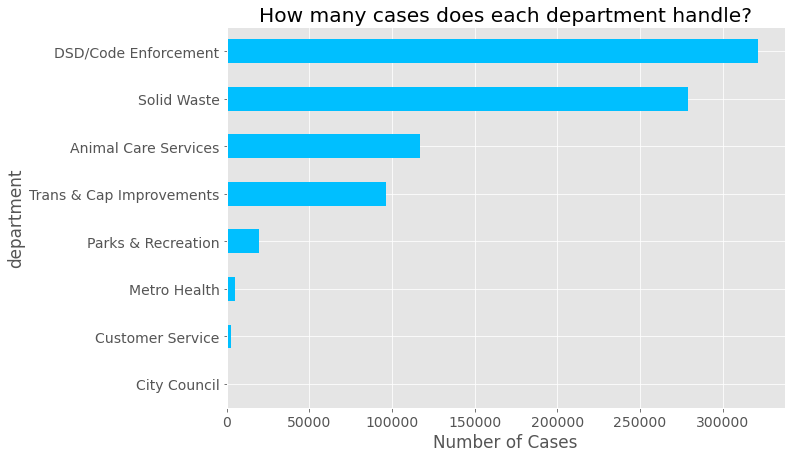

In [24]:
df.groupby("department").count().toPandas().set_index('department')['count'].sort_values().plot.barh()

plt.xlabel('Number of Cases')
plt.title('How many cases does each department handle?')

Does the percentage of cases that are late vary by department?

In [26]:
late_cases_by_dept = df.withColumn("case_late", col("case_late").cast("int")).groupby("department").agg(round(avg("case_late"), 2).alias("p_cases_late"))
late_cases_by_dept.show()

+--------------------+------------+
|          department|p_cases_late|
+--------------------+------------+
|         Solid Waste|        0.12|
|Animal Care Services|         0.2|
|Trans & Cap Impro...|        0.06|
|  Parks & Recreation|        0.19|
|    Customer Service|        0.71|
|        Metro Health|        0.16|
|        City Council|         0.0|
|DSD/Code Enforcement|        0.08|
+--------------------+------------+



Text(0.5, 1.0, 'What percentage of cases are late in each department?')

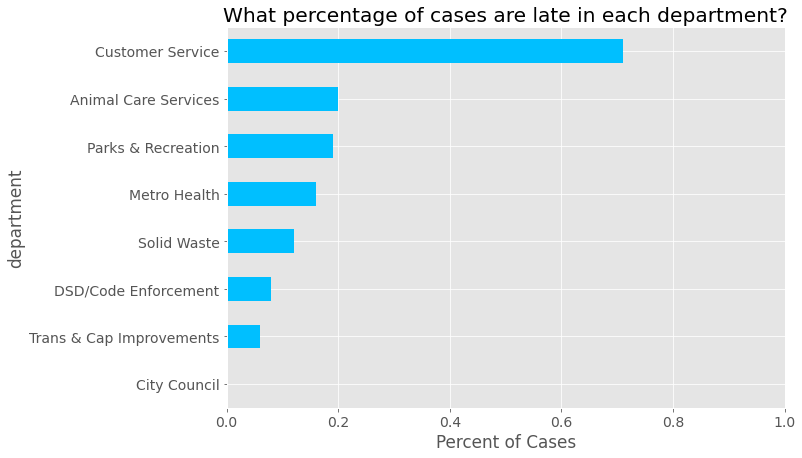

In [31]:
late_cases_by_dept.toPandas().set_index('department')['p_cases_late'].sort_values().plot.barh()

plt.xlabel('Percent of Cases')
plt.xlim(0, 1)
plt.title('What percentage of cases are late in each department?')

On average, how late are the late cases by department?

In [35]:
days_late_by_dept = df.filter("case_late = 'True'").withColumn("num_days_late", col("num_days_late").cast("int")).groupby("department").agg(round(avg("num_days_late"), 2).alias("avg_days_late"))
days_late_by_dept.show()

+--------------------+-------------+
|          department|avg_days_late|
+--------------------+-------------+
|         Solid Waste|         6.84|
|Animal Care Services|        23.02|
|Trans & Cap Impro...|        10.26|
|  Parks & Recreation|        21.81|
|    Customer Service|        87.17|
|        Metro Health|         6.05|
|DSD/Code Enforcement|         48.9|
+--------------------+-------------+



Text(0.5, 1.0, 'How late are the late cases by department?')

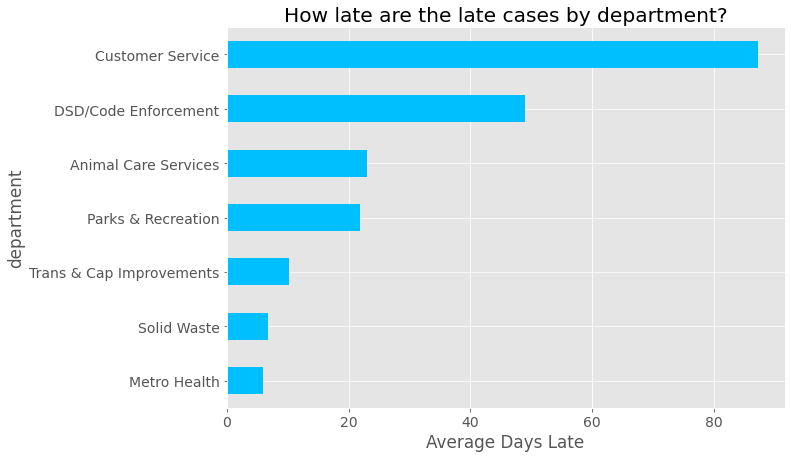

In [39]:
days_late_by_dept.toPandas().set_index('department')['avg_days_late'].sort_values().plot.barh()

plt.xlabel('Average Days Late')
plt.title('How late are the late cases by department?')

What is the service type that is the most late? Just for Parks & Rec?

In [40]:
late_services = df.filter("case_late = 'True'").withColumn("num_days_late", col("num_days_late").cast("int")).groupby("service_request_type").agg(round(avg("num_days_late"), 2).alias("avg_days_late"))
late_services.show()

+--------------------+-------------+
|service_request_type|avg_days_late|
+--------------------+-------------+
|        Tree Removal|        39.71|
| Service Information|        37.74|
|Minimum Housing-O...|        57.52|
|    Sign Maintenance|        21.65|
|Park Building Mai...|        58.74|
|Brush Property Da...|         3.67|
|Graffiti: Private...|        113.8|
|License Renewal I...|         2.68|
|Traffic Sign Graf...|         3.92|
|Markings Installa...|        61.75|
|Guardrail- New Re...|         41.0|
|   Sewer Line Broken|        33.73|
|Zoning: Multi-Fam...|        66.39|
|Engineering Inves...|         1.33|
|    Zoning: Setbacks|        86.24|
|     Permits, Fences|        42.28|
|Certificates of O...|        77.11|
|  Traffic Sign Faded|         2.54|
|  Dead Animal - Misc|         1.68|
|Garage Sales No P...|         18.4|
+--------------------+-------------+
only showing top 20 rows



In [41]:
late_services.shape()

(294, 2)

There are 294 different service request types that have late cases, so I'm only going to select the top 12.

In [47]:
late_services = late_services.sort(desc("avg_days_late"))
late_services = late_services.filter("avg_days_late > 115.0")
late_services.show()

+--------------------+-------------+
|service_request_type|avg_days_late|
+--------------------+-------------+
|Zoning: Recycle Yard|        210.4|
|  Zoning: Junk Yards|       199.72|
|Structure/Housing...|       189.76|
|Donation Containe...|       170.66|
|Storage of Used M...|       163.43|
|Labeling for Used...|        162.0|
|Record Keeping of...|       153.57|
|Signage Requied f...|       151.08|
|Traffic Signal Gr...|        137.0|
|License Requied U...|       128.14|
|         Curbstoning|        120.0|
|             Vendors|       117.35|
+--------------------+-------------+



Text(0.5, 1.0, 'What is the service type that is the most late?')

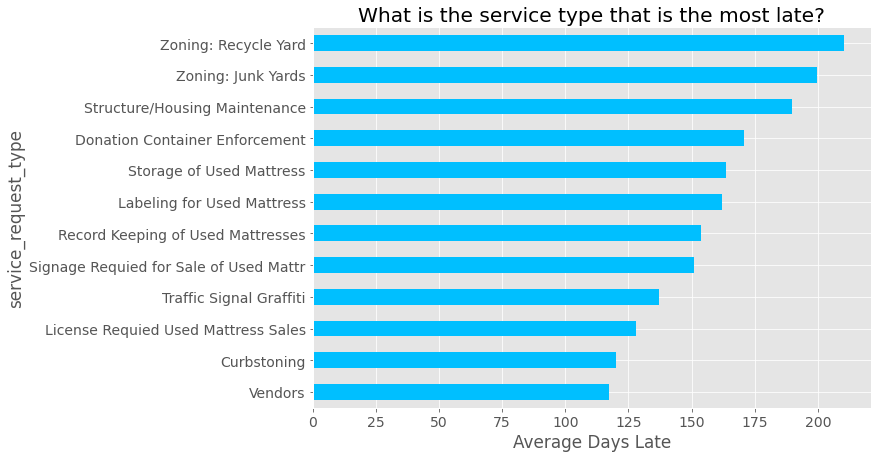

In [51]:
late_services.toPandas().set_index('service_request_type')['avg_days_late'].sort_values().plot.barh()

plt.xlabel('Average Days Late')
plt.title('What is the service type that is the most late?')

In [62]:
# Now, just in Parks & Rec...

late_services_PnR = df.filter("department = 'Parks & Recreation'").filter("case_late = 'True'").withColumn("num_days_late", col("num_days_late").cast("int")).groupby("service_request_type").agg(round(avg("num_days_late"), 2).alias("avg_days_late")).sort(desc("avg_days_late"))
late_services_PnR.show()

+--------------------+-------------+
|service_request_type|avg_days_late|
+--------------------+-------------+
|Amenity Park Impr...|        76.24|
|Major Park Improv...|        75.18|
|Reservation Assis...|         65.5|
|Park Building Mai...|        58.74|
| Sportfield Lighting|        50.88|
|          Electrical|        42.35|
|        Tree Removal|        39.71|
|Landscape Mainten...|        38.26|
|     Heavy Equipment|        38.16|
|Miscellaneous Par...|        33.02|
|Tree Trimming/Mai...|        30.14|
|General Building ...|         27.7|
|             Masonry|        27.24|
|            Painting|        24.86|
|    Sign Maintenance|        21.65|
|   Fence/Gate Repair|        19.72|
|Small Equipment R...|        19.17|
|               Pools|        19.03|
|            Plumbing|        17.98|
|Plumbing/Drinking...|        17.49|
+--------------------+-------------+
only showing top 20 rows



In [63]:
late_services_PnR.shape()

(44, 2)

Text(0.5, 1.0, 'What is the service type that is the most late in Parks & Rec?')

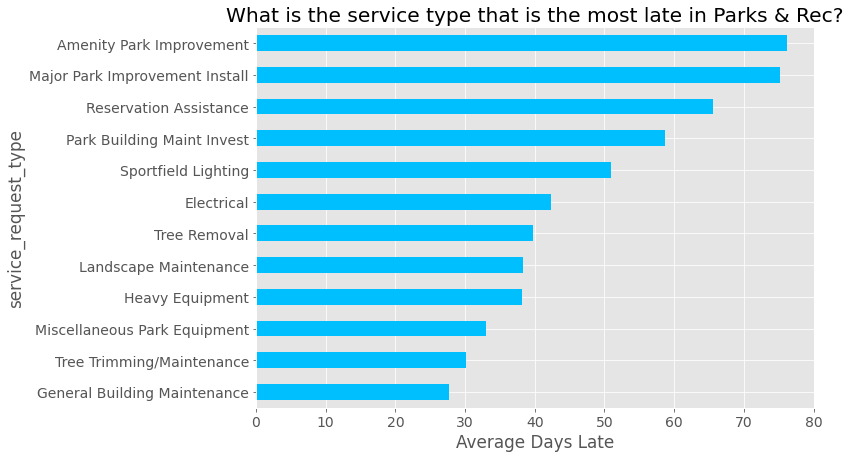

In [65]:
late_services_PnR.filter("avg_days_late > 27.3").toPandas().set_index('service_request_type')['avg_days_late'].sort_values().plot.barh()

plt.xlabel('Average Days Late')
plt.title('What is the service type that is the most late in Parks & Rec?')

In [32]:
df.printSchema()

root
 |-- case_id: integer (nullable = true)
 |-- case_opened_date: timestamp (nullable = true)
 |-- case_closed_date: timestamp (nullable = true)
 |-- case_due_date: timestamp (nullable = true)
 |-- case_late: boolean (nullable = true)
 |-- num_days_late: double (nullable = true)
 |-- case_closed: boolean (nullable = true)
 |-- service_request_type: string (nullable = true)
 |-- SLA_days: double (nullable = true)
 |-- case_status: string (nullable = true)
 |-- source_id: string (nullable = true)
 |-- request_address: string (nullable = true)
 |-- council_district: string (nullable = false)
 |-- num_weeks_late: double (nullable = true)
 |-- zipcode: string (nullable = true)
 |-- case_age: integer (nullable = true)
 |-- days_to_closed: integer (nullable = true)
 |-- case_lifetime: integer (nullable = true)
 |-- department: string (nullable = true)
 |-- dept_subject_to_SLA: boolean (nullable = true)



For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.